# Find a Pup!
Given an input image of a puppy, find closely related puppies based on the distances between their feature vectors. 

## Overview


1.   Use fully connected layer from VGG-16 model to get image feature vectors
2.   Add image feature vectors to annoy index for closest neighbour search
3.   Display resulting closest neighbours

## Running Notebook
From the top menu, select **Runtime -> Run all**. Alternatively, press `Ctrl + F9`



### Import Neccessary Modules

In [1]:
# Used for vector search
!pip install annoy

     |████████████████████████████████| 646 kB 7.1 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391650 sha256=835601ad62413a7fd6b9b927a2b9de1eb6c026c27056ab946d8e9c197d4f2c82
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [2]:
from annoy import AnnoyIndex
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
import numpy as np
import os
from pathlib import Path
import sys

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

## Gather Images to Search
We will be using the Stanford Dogs Dataset 🐶 as our image repo that we want to find similar images in.

In [3]:
root = Path(Path.home())
image_dir = Path(Path.home()) / "Images"

In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar xf images.tar -C $root

--2022-01-19 19:30:40--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  10.6MB/s    in 72s     

2022-01-19 19:31:52 (10.6 MB/s) - ‘images.tar’ saved [793579520/793579520]



## Feature Vector Extactor
This is the class we will be using to extract feature vectors from each image. The model we will be using is the `VGG-16` architecture trained on `imagenet` weights.

In [5]:
class ImageFeatureExtractor: 
  def __init__(self):
    # Use VGG-16 as the architecture and ImageNet for the weight
    base_model = VGG16(weights='imagenet')
    # Return features from fully connected layer 
    self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
  
  def extract_image(self, img, print_shape=False):
    # Resize image and convert colour space
    img = img.resize((224, 224))
    img = img.convert('RGB')

    # Reformat Image to fit VGG-16 input dimensions
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    if print_shape:
      print("Shape of image:", img.shape)

    # Extract Features
    feature_vec = self.model.predict(img)[0]

    return feature_vec

  def get_feature_vectors(self, image_root_path):
    vectors = []
    image_paths = []

    image_folders = [folder for folder in os.listdir(image_root_path)]

    for idx, folder in enumerate(image_folders): 
      if not idx or not (idx + 1) % 5:
        print(f"Extracting folder {idx+1} out of {len(image_folders)}...")

      image_names = [name for name in os.listdir(image_root_path / folder)]
      
      # Extract images
      for img_name in image_names[:min(10, len(image_names))]:
        img_path = str(image_root_path / folder / img_name)
        img = image.load_img(img_path)

        vec = self.extract_image(img)

        vectors.append(vec)
        image_paths.append(f"{folder}/{img_name}")

    return vectors, image_paths

### Instantiate Extractor and Extract

In [6]:
extractor = ImageFeatureExtractor()
vectors, image_paths = extractor.get_feature_vectors(image_dir)

print("Total Images Extracted:", len(vectors))

553476096/553467096 [==============================] - 3s 0us/step
Extracting folder 1 out of 120...
Extracting folder 5 out of 120...
Extracting folder 10 out of 120...
Extracting folder 15 out of 120...
Extracting folder 20 out of 120...
Extracting folder 25 out of 120...
Extracting folder 30 out of 120...
Extracting folder 35 out of 120...
Extracting folder 40 out of 120...
Extracting folder 45 out of 120...
Extracting folder 50 out of 120...
Extracting folder 55 out of 120...
Extracting folder 60 out of 120...
Extracting folder 65 out of 120...
Extracting folder 70 out of 120...
Extracting folder 75 out of 120...
Extracting folder 80 out of 120...
Extracting folder 85 out of 120...
Extracting folder 90 out of 120...
Extracting folder 95 out of 120...
Extracting folder 100 out of 120...
Extracting folder 105 out of 120...
Extracting folder 110 out of 120...
Extracting folder 115 out of 120...
Extracting folder 120 out of 120...
Total Images Extracted: 1200


## Generate AnnoyIndex for Vector Matching
We will be using the Annoy library from Spotify (https://github.com/spotify/annoy) to find the nearest neighbours for a feature vector. This will be used to approximate the similarity between two images for our search.

In [59]:
class AnnoyTree: 
  def __init__(self, dims, n_trees, vectors=None):
    self.tree = AnnoyIndex(dims, metric='euclidean')

    if vectors is not None: 
      for idx, vec in enumerate(vectors):
        self.tree.add_item(idx, vec)
    
    print("Building the tree... 🌲 🌲 🌲")
    self.tree.build(n_trees)
    print("Tree has been built! 🌲 🌲 🌲")
    print(f"Tree size: {self.tree.get_n_items()}".ljust(21) + "🌲 🌲 🌲")


  def add_item(self, vec):
    self.tree.add_item(self.tree.get_n_items(), vec)

  def get_neighbours_w_idx(self, idx, n_neighbours):
    return self.tree.get_nns_by_item(idx, n_neighbours, include_distances=True)

  def get_neighbours_w_vec(self, vec, n_neighbours):
    return self.tree.get_nns_by_vector(vec, n_neighbours, include_distances=True)


### Instantiate AnnoyIndex for Vector Search

In [60]:
 annoy_tree = AnnoyTree(4096, 5000, vectors)

Building the tree... 🌲 🌲 🌲
Tree has been built! 🌲 🌲 🌲
Tree size: 1200      🌲 🌲 🌲


# Search for Puppies! 🐶



Original Pup:                🐶 🐶 🐶




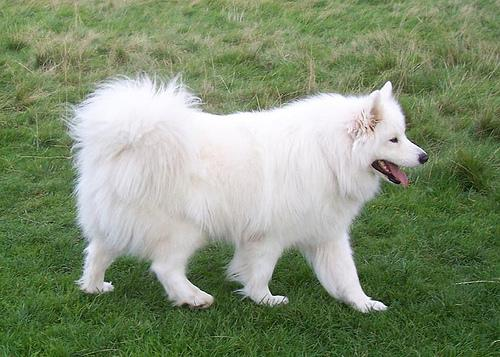



Searching for similar pups... 🐶 🐶 🐶




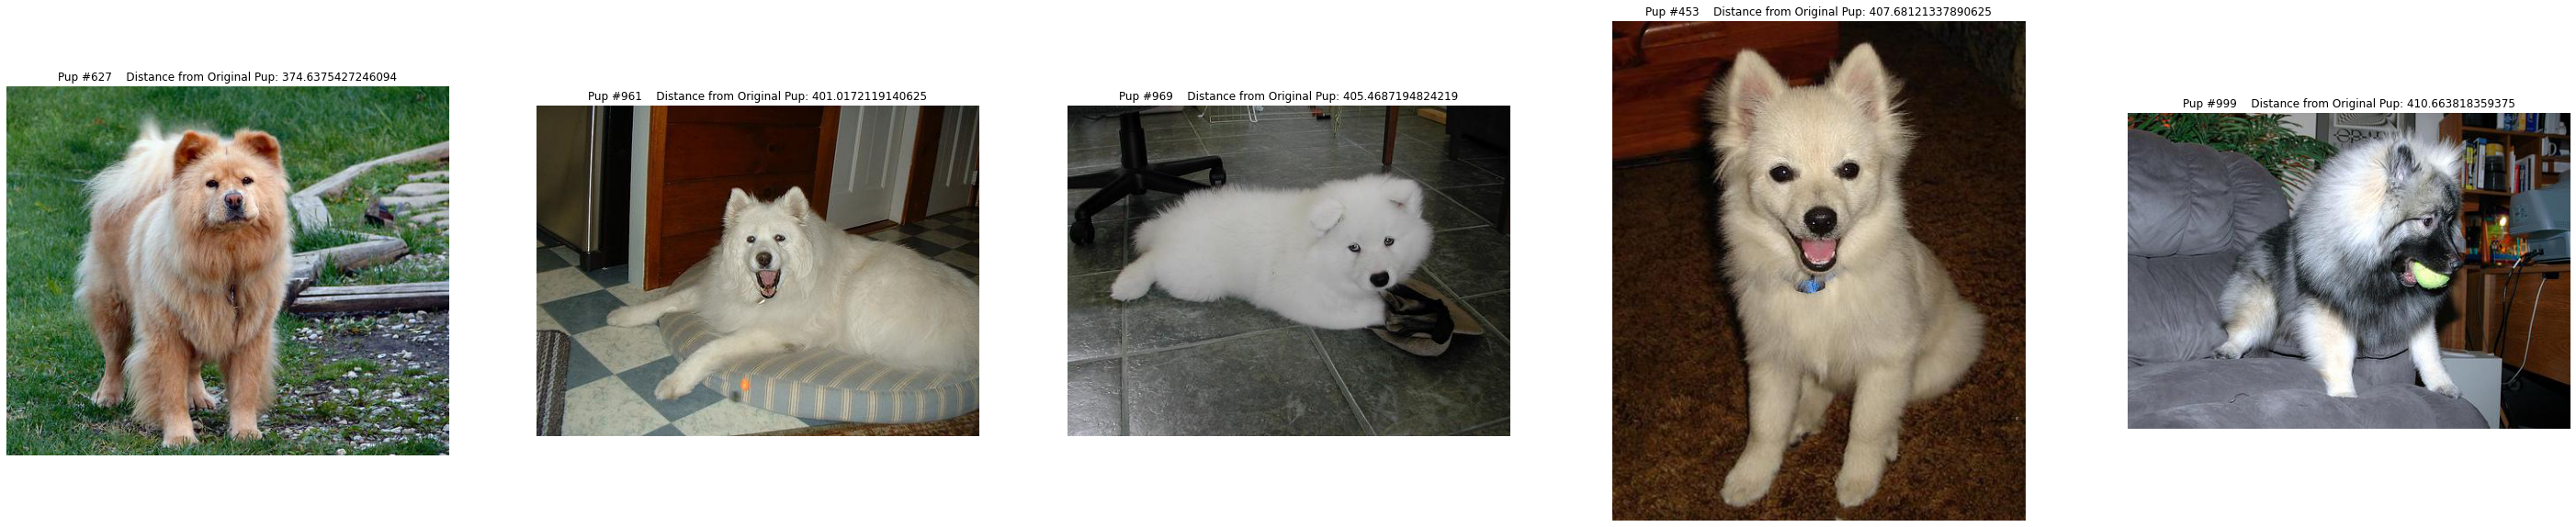

In [67]:
#@title #Search for Pups 🐶 { run: "auto" }

Pup = "Samoyed" #@param ["Wired Haired Fox Terrier", "Samoyed", "English Setter", "Cocker Spaniel", "Newfoundland", "Groenedael", "Affenpinscher", "Redbone", "Maltese", "Lhasa", "Dingo"]

pup_to_idx = {
    "Samoyed" : 966,
    "English Setter" : 1193,
    "Cocker Spaniel" : 13,
    "Newfoundland" : 1169,
    "Groenedael" : 1027,
    "Affenpinscher" : 1100,
    "Redbone" : 1010,
    "Maltese" : 219,
    "Lhasa" : 879,
    "Dingo" : 360,
    "Wired Haired Fox Terrier" : 100
}

pup_idx = pup_to_idx[Pup]
n_res = 5

print("""

Original Pup:                🐶 🐶 🐶

""")

img_path = str(image_dir / image_paths[pup_idx])
img = image.load_img(img_path)

cv2_img = cv2.imread(img_path)
cv2_imshow(cv2_img)

print("""

Searching for similar pups... 🐶 🐶 🐶

""")

fig = plt.figure(figsize=(50, 10))

nearest, distances = annoy_tree.get_neighbours_w_idx(pup_idx, n_res + 1)

for idx, nn in enumerate(nearest):
  if not nn == pup_idx:
    fig.add_subplot(1, n_res, idx)

    plt.axis('off')
    plt.title(f"Pup #{nn}    Distance from Original Pup: {distances[idx]}")
    plt.imshow(image.load_img(str(image_dir / image_paths[nn])))

# Thanks for checking this out! 🐕🐕🐕

## References
The following sources were extremeley helpful: 

https://keras.io/examples/vision/siamese_network/ 

https://www.tensorflow.org/hub/tutorials/tf_hub_delf_module 

https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509 

https://www.analyticsvidhya.com/blog/2021/01/querying-similar-images-with-tensorflow/ 

https://github.com/spotify/annoy 